In [31]:
import torch
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt 

torch.manual_seed(3) 

n = 1

class MeanField(torch.nn.Module):
    
    def __init__(self, q, w, sig, h, lam):
        super().__init__()  
        
        # Initial guess for mean and variance of neuronal input 
        ts_init = 0.31 # mean neuronal input
        ssq_init = 2.36 # variance of neuronal input

        self.ts = torch.nn.Parameter(torch.tensor(ts_init)) # mean/std of neuronal input
        self.ssq = torch.nn.Parameter(torch.tensor(ssq_init)) # std of neuronal input 

        self.t = self.ts/torch.sqrt(self.ssq)

        
        # Model parameters
        self.q = q # proportion 
        self.w = w # mean synaptic weight 
        self.sig = sig # variance of synaptic weight
        self.h = h # mean input 
        self.lam = lam # variance of input 

    def forward(self):

        # Mean neuronal input 
        ts_now = self.ts
        self.t = self.ts/torch.sqrt(self.ssq)

        transfer1 = 0.5 * (self.t**2 + 1) * (torch.erf(self.t / torch.sqrt(torch.tensor(2.0))) + 1) 
        transfer1 += 1 / (torch.sqrt(2 * torch.tensor(np.pi))) * self.t * torch.exp(-self.t**2 / 2) 
        # transfer1 = self.t**2 # approximate version 
        mean_rate = (self.ssq) * transfer1
        ts_recur = self.h + self.w * self.q * mean_rate

        # Variance of neuronal input 
        ssq_now = self.ssq

        transfer2 = 0.5 * (self.t**4 + 6*self.t**2 + 3) * (torch.erf(self.t / torch.sqrt(torch.tensor(2.0))) + 1) 
        transfer2 += 1 / (torch.sqrt(2 * torch.tensor(np.pi))) * self.t * (self.t**2 + 5) * torch.exp(-self.t**2 / 2)
        # transfer2 = self.t**4 + 6*self.t**2 # approximate version 
        # transfer2 = self.t**4 # approximate version
        var_rate = (self.ssq)**2 * transfer2
        ssq_recur = self.lam + self.sig**2 * self.q * var_rate

        return ts_recur, ssq_recur, mean_rate, var_rate

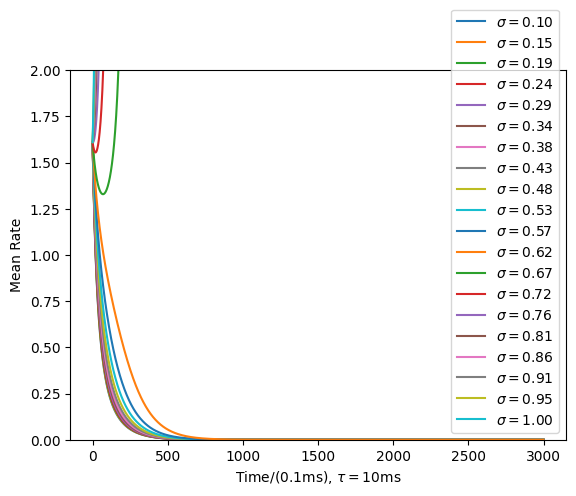

In [65]:
m = 3000 # Total steps for evolution
tau = 10 # (ms). Time constant of the rate model 
Delta_t = 0.1 # (ms). Time interval for numerical integration 

eps = Delta_t / tau 

def get_traj (q, w, sig, h, lam) :
     
    traj = [] # Rate trajectory stored every step. 

    # Instantiate model 
    mf = MeanField(q, w, sig, h, lam)

    for iter in range(m) : 
        
        # traj.append([mf.ts.detach().values, mf.ssq.detach().values])
        ts_recur, ssq_recur, mean_rate, var_rate = mf()
        
        mf.ts.data = mf.ts + eps * (-mf.ts + ts_recur)
        mf.ssq.data = mf.ssq + eps * (-mf.ssq + ssq_recur)

        traj.append ( [mean_rate.data.item(), var_rate.data.item()] )

    traj = np.asarray(traj)

    return traj 


q = torch.FloatTensor(np.ones(shape=(n,)))
w = torch.FloatTensor(np.ones(shape=(n,n))) * -1
sig = torch.FloatTensor(np.ones(shape=(n,n))) * 0.1
h = torch.FloatTensor(np.ones(shape=(n,))) * 0
lam = torch.FloatTensor(np.ones(shape=(n,))) * 0

_n_sig_vals = 20
sig_val_list = np.linspace(0.1, 1, _n_sig_vals)
traj_list = [] 
for sig_val in sig_val_list : 
    sig = torch.FloatTensor(np.ones(shape=(n,n))) * sig_val
    traj = get_traj(q, w, sig, h, lam)
    traj_list.append(traj)
traj_list = np.asarray(traj_list)

for i in range(_n_sig_vals) : 
    traj = traj_list[i]
    sig_val = sig_val_list[i]
    plt.plot(traj[:,0], '-', label=rf'$\sigma=${sig_val:.2f}')
    
plt.xlabel(rf'Time/({Delta_t}ms), $\tau=${tau}ms')
plt.ylabel('Mean Rate')
plt.ylim(0,2)
plt.legend()
plt.show()

# plt.plot(traj[:,1], '-o')
# plt.xlabel(rf'Time/({Delta_t}ms), $\tau=${tau}ms')
# plt.ylabel('Var Rate')
# plt.show()
    

(0.0, 1.0)

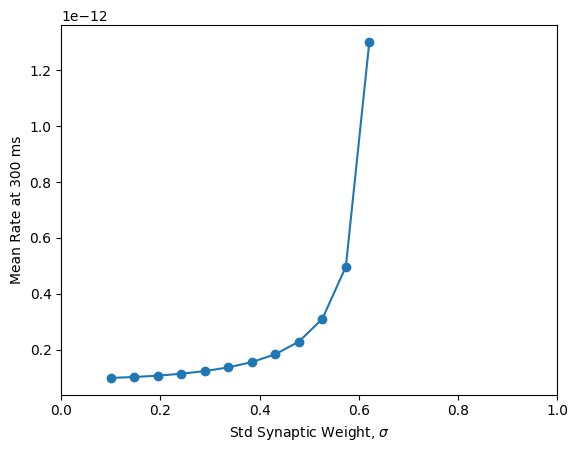

In [68]:
plt.plot(sig_val_list, traj_list[:, -1, 0], '-o')
plt.xlabel(r'Std Synaptic Weight, $\sigma$')
plt.ylabel('Mean Rate at 300 ms')
plt.xlim(0,1)

In [79]:
q = torch.FloatTensor(np.ones(shape=(n,)))
w = torch.FloatTensor(np.ones(shape=(n,n))) * -1
sig = torch.FloatTensor(np.ones(shape=(n,n))) * 0.1
h = torch.FloatTensor(np.ones(shape=(n,))) * 0
lam = torch.FloatTensor(np.ones(shape=(n,))) * 0

_n_h_vals = 20
h_val_list = np.linspace(0, 1, _n_h_vals)
traj_list = [] 
for h_val in h_val_list : 
    h = torch.FloatTensor(np.ones(shape=(n,n))) * h_val
    traj = get_traj(q, w, sig, h, lam)
    traj_list.append(traj)
traj_list = np.asarray(traj_list)

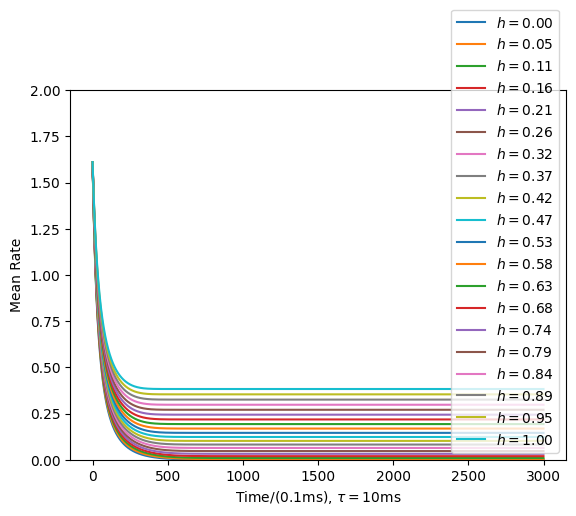

In [77]:
for i in range(_n_h_vals) : 
    traj = traj_list[i]
    h_val = h_val_list[i]
    plt.plot(traj[:,0], '-', label=rf'$h=${h_val:.2f}')
    
plt.xlabel(rf'Time/({Delta_t}ms), $\tau=${tau}ms')
plt.ylabel('Mean Rate')
plt.ylim(0,2)
plt.legend()
plt.show()

(0.0, 1.0)

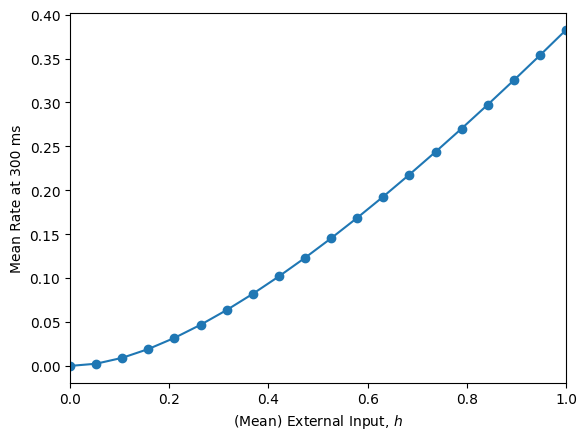

In [78]:
plt.plot(h_val_list, traj_list[:, -1, 0], '-o')
plt.xlabel(r'(Mean) External Input, $h$')
plt.ylabel('Mean Rate at 300 ms')
plt.xlim(0,1)